In [1]:
import nltk
from nltk import FreqDist
import string
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [2]:
def get_stream_details():
    print("Reading the stream details...")
    complete_stream_details_df = pd.read_csv("H:\\TeamStreamz_IW\\code\\data\\card_module_details_content_extracted.csv", encoding="ISO-8859-1")
    if complete_stream_details_df is not None:
        complete_stream_details_dict = {}
        _stream_id_stream_title_dict = {}
        for _, row in complete_stream_details_df.iterrows():
            
            stream_id = str(row["DECKID"])
            stream_title = str(row["DECKNAME"])
            row_content = str(row["HTML_CONTENT"])

            # TODO: add the card title and the module name to the content on which the tags can be generated
            card_title =str(row["CARDTITLE"])
            module_name = str(row["MODULENAME"])
            
            if row_content and "nan" not in row_content:
                # if the stream ID already exists in the dictionary
                if complete_stream_details_dict.get(stream_id):
                    existing_content = complete_stream_details_dict[stream_id]
                    new_content = existing_content + "\n" + row_content.strip()
                    complete_stream_details_dict[stream_id] = new_content
                else:
                    complete_stream_details_dict[stream_id] = row_content.strip()
                    _stream_id_stream_title_dict[stream_id] = stream_title
        
        return complete_stream_details_dict

In [3]:
stream_details_dict = get_stream_details()
stream_details_dict

Reading the stream details...


{'1089': 'Welcome Team! Were really glad you are part of this journey!     In this stream you will find out more about the program and its fantastic benefits.     But first, scroll to the next card to complete a small survey, to help us guide your ...\nThis tool is used to capture the brand survey information.       "On a scale of 1-10, how likely are you to recommend a Castrol brand to a customer?"       You cannot edit this c...\n{"title": "Brand Survey", "primaryField": "field1", "page1": {"header": "{CARD_DESCRIPTION}", "field1": {"type": "Text", "name": "NPS Score", "sequence": 1}, "sequence": 1}, "maxSubmissions": 1}\nUp-to-date       knowledge on Castrol Brand 123 messaging\nInteractive quizzes to let you        track your progress       and growth\nBadges and Competitions that entitle you to        great gifts and rewards!\nThe Castrol Zoom App provides interactive information, competitions and rewards on all things Castrol!     Enjoy the journey!',
 '1095': 'In this Stream you

In [4]:
len(stream_details_dict)

112

## So we have 112 documents with the contents given by the values

In [5]:
# what is the content length
stream_details_df = pd.DataFrame(list(stream_details_dict.items()), columns = ["StreamID", "Content"])
stream_details_df["ContentLength"] = stream_details_df["Content"].str.len()
stream_details_df.head()

,StreamID,Content,ContentLength
0,163,TXmAk2KZAy4\nNMeUjebo1Ac\nEEuTxFhp3go\nCastrol...,800
1,419,TXmAk2KZAy4\nNMeUjebo1Ac\nEEuTxFhp3go\nCastrol...,812
2,507,"wBYKUgUyGWc\nA team of world-class drivers, po...",180
3,199,Castrol EDGE is Castrols flagship power b...,1505
4,201,"Charles Cheers Wakefield, Castrols founder, wa...",1675


In [6]:
# largest, average and minimum
stream_details_df["ContentLength"] = stream_details_df["ContentLength"].astype(float)
stream_details_df["ContentLength"].describe()

count     112.000000
mean      833.473214
std       705.489160
min         7.000000
25%       274.000000
50%       694.000000
75%      1136.250000
max      3418.000000
Name: ContentLength, dtype: float64

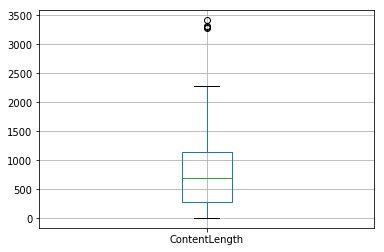

In [7]:
boxplot = stream_details_df.boxplot(column=['ContentLength'])
plt.show()

### Pre-process the file using text pre-processing steps

In [8]:
# convert case, remove punctuations
# stem the words
stop = stopwords.words('english')
snowball = nltk.SnowballStemmer('english')

def preprocess(toks):
    toks = [ t.lower() for t in toks if t not in string.punctuation ]
    toks = [t for t in toks if t not in stop ]
    toks = [ snowball.stem(t) for t in toks ]
#   toks = [ wnl.lemmatize(t) for t in toks ]
    toks_clean = [ t for t in toks if len(t) >= 3 ]
    return toks_clean

all_streams_cleaned_tokens = []
for _, row in stream_details_df.iterrows():
    stream_content = row["Content"]
    stream_content_tokens = nltk.word_tokenize(stream_content)
    stream_cleaned_tokens = preprocess(stream_content_tokens)
    all_streams_cleaned_tokens.append(stream_cleaned_tokens)

all_streams_cleaned_tokens_flat = [ c for l in all_streams_cleaned_tokens for c in l ]

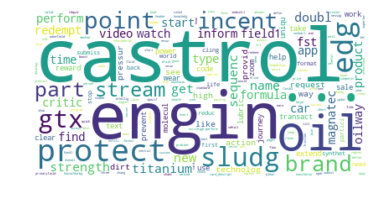

In [9]:
fd_all_stream_tokens = FreqDist(all_streams_cleaned_tokens_flat)
wc_stream_tokens = WordCloud(background_color="white").generate_from_frequencies(fd_all_stream_tokens)
plt.imshow(wc_stream_tokens, interpolation='bilinear')
plt.axis("off")
plt.show()

### Term frequency for the terms

In [10]:
len(all_streams_cleaned_tokens)

112

In [11]:
# check the frequencies
# perform TF-IDF to get the scores for words for each document
# generate the tags based on the TF-IDF scores
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

all_streams_cleaned_text = [ ' '.join(f) for f in all_streams_cleaned_tokens ]
print(len(all_streams_cleaned_text))
print(len(all_streams_cleaned_text[0]))
print(len(all_streams_cleaned_text[1]))
print(len(all_streams_cleaned_text[2]))
print(len(all_streams_cleaned_text[3]))

112
518
530
115
999


In [12]:
all_streams_count_vectorizer = CountVectorizer(min_df = 2)
all_streams_tf = all_streams_count_vectorizer.fit_transform(all_streams_cleaned_text)

In [13]:
all_streams_tf

<112x827 sparse matrix of type '<class 'numpy.int64'>'
	with 5107 stored elements in Compressed Sparse Row format>

### TFIDF vectorizer for the terms

In [14]:
# And tfidf indexing
all_streams_tfidf_vectorizer = TfidfVectorizer(min_df = 2)
all_streams_tfidf = all_streams_tfidf_vectorizer.fit_transform(all_streams_cleaned_text)
all_streams_tfidf

<112x827 sparse matrix of type '<class 'numpy.float64'>'
	with 5107 stored elements in Compressed Sparse Row format>

In [15]:
len(all_streams_tfidf_vectorizer.vocabulary_)

827

In [16]:
import pickle
pickle.dump(all_streams_tfidf, open("outputs/all_streams_tfidf.pkl", "wb"))
pickle.dump(all_streams_tfidf_vectorizer.vocabulary_, open("outputs/terms.pkl","wb"))

In [17]:
#load the content
loaded_vec = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("outputs/terms.pkl", "rb")))
all_streams_tfidf = pickle.load(open("outputs/all_streams_tfidf.pkl", "rb" ) )
all_streams_tfidf

<112x827 sparse matrix of type '<class 'numpy.float64'>'
	with 5107 stored elements in Compressed Sparse Row format>

In [18]:
all_streams_tfidf.shape

(112, 827)

In [21]:
all_streams_tfidf_coo = all_streams_tfidf.tocoo()
len(all_streams_tfidf_coo.row)

5107

In [22]:
len(all_streams_tfidf_coo.col)

5107

In [26]:
pd.Series(all_streams_tfidf_coo.row).describe()

count    5107.000000
mean       52.425494
std        30.799957
min         0.000000
25%        29.000000
50%        51.000000
75%        81.000000
max       111.000000
dtype: float64

In [30]:
all_streams_tfidf_coo.row[-10:]

array([111, 111, 111, 111, 111, 111, 111, 111, 111, 111])

In [31]:
all_streams_tfidf_coo.col[-10:]

array([181, 286, 435,  75, 580, 333,  72, 585, 654,  65])

In [32]:
all_streams_tfidf_coo.data[-10:]

array([0.08915615, 0.45876383, 0.18220699, 0.08397086, 0.07336801,
       0.32969267, 0.26197056, 0.0911035 , 0.13098528, 0.11875105])

In [34]:
K = 5

In [33]:
# create a dictionary indexed by the stream (row) number
token_tfidf_dict = {}
for idx, stream_index in enumerate(all_streams_tfidf_coo.row):
    if token_tfidf_dict.get(stream_index):
        token_tfidf_dict[stream_index].append((all_streams_tfidf_coo.col[idx], all_streams_tfidf_coo.data[idx]))
    else:
        token_tfidf_dict[stream_index] = [(all_streams_tfidf_coo.col[idx], all_streams_tfidf_coo.data[idx])]
        
assert(len(token_tfidf_dict) == all_streams_tfidf.shape[0])

In [38]:
for k in token_tfidf_dict:
    num_tokens = min(K, len(token_tfidf_dict[k]))
    top_k_token_ids = sorted(token_tfidf_dict[k], key=lambda x: x[1], reverse=True)[: num_tokens]
    token_tfidf_dict[k]= top_k_token_ids
    

In [39]:
token_tfidf_dict

{0: [(141, 0.3717215509262681),
  (624, 0.24781436728417872),
  (737, 0.2372900771893382),
  (221, 0.21070480583097215),
  (713, 0.1489929034968167)],
 1: [(141, 0.3717215509262681),
  (624, 0.24781436728417872),
  (737, 0.2372900771893382),
  (221, 0.21070480583097215),
  (713, 0.1489929034968167)],
 2: [(123, 0.3301723391343141),
  (184, 0.3301723391343141),
  (135, 0.30965186624210106),
  (221, 0.2807298841082772),
  (412, 0.2807298841082772)],
 3: [(231, 0.36005317546943477),
  (309, 0.3108513776104754),
  (737, 0.2974109710548564),
  (685, 0.2974109710548564),
  (504, 0.2463418102393168)],
 4: [(543, 0.2674612060676914),
  (113, 0.2349113281232128),
  (800, 0.1842054786841621),
  (432, 0.18075277018664537),
  (488, 0.17770082197413214)],
 5: [(543, 0.26707119614486596),
  (113, 0.23456878218805025),
  (800, 0.18393687163799685),
  (432, 0.18048919785409132),
  (488, 0.17744169996955025)],
 6: [(113, 1.0)],
 7: [(113, 1.0)],
 8: [(113, 1.0)],
 9: [(677, 0.3568807902372673),
  (435,